<a href="https://colab.research.google.com/github/JUNYA-727/bitcoin_system_trading/blob/main/bitcoin_model_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ビットコインを自動売買のモデルで作成する。**

**APIを使って自動売買を行う前に、シミュレーションを行って勝率、利益を考えてみる。**
*   特徴量はTa-LIbをテクニカル指標を導入する。
*   TensorflowのLSTM、パラメーター最適化Optunaを加えたLightGBMのこれら2つを使って比較を行い、最も高い勝率、利益率のモデルを自動売買のアルゴリズムとして導入を検討する。




In [ ]:
#特徴量として使用するテクニカル指標の計算のライブラリ
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [9]:
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np

### データは時系列に並べており、左のコラムから[時間、始値、高値、安値、終値、出来高]
### 短期売買を目的としているため、今回は15分ごとのデータから予測を行う

In [126]:
df=pd.read_csv('/content/drive/MyDrive/btc 9月12日-11月26日.csv')
df

,2021-09-12 14:45:00,45853.99,45857.72,45842.03,45857.72.1,0.8006
0,2021-09-12 15:00:00,45896.18,45896.18,45819.53,45819.53,0.500400
1,2021-09-12 15:15:00,45813.99,45813.99,45813.99,45813.99,0.010000
2,2021-09-12 15:45:00,45834.92,45834.92,45747.05,45747.05,1.760000
3,2021-09-12 16:00:00,45807.04,45881.14,45807.04,45881.14,0.018020
4,2021-09-12 16:15:00,45881.14,45881.14,45881.14,45881.14,1.278035
...,...,...,...,...,...,...
5994,2021-11-26 13:45:00,54293.16,54421.48,54276.06,54388.82,0.307000
5995,2021-11-26 14:00:00,54468.70,54591.47,54459.06,54591.47,0.459667
5996,2021-11-26 14:15:00,54731.51,54731.51,54559.06,54671.26,1.762644
5997,2021-11-26 14:30:00,54785.51,54933.69,54785.51,54933.69,0.651511


In [127]:
#今回は終値だけに注目して使用する。
df1=df.iloc[0:,4:5]
df1.columns=['price']

In [128]:
df1

,price
0,45819.53
1,45813.99
2,45747.05
3,45881.14
4,45881.14
...,...
5994,54388.82
5995,54591.47
5996,54671.26
5997,54933.69


In [129]:
#特徴量の追加
#特徴量はボリンジャーバンド、SMA、RSI、MACDを使用する。
df1['sma20']=talib.SMA(df1['price'],timeperiod=20)
up,middle,low=talib.BBANDS(df1['price'],timeperiod=20,nbdevdn=3,nbdevup=3,matype=0)
df1['bb_up']=up
df1['bb_low']=low

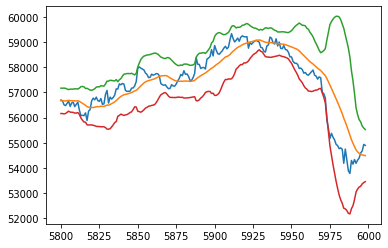

In [130]:
plt.plot(df1[5800:])

In [131]:
macd,macdsignal,macdhist=talib.MACD(df1['price'],fastperiod=12,slowperiod=26,signalperiod=9)
df1['macd']=macd
df1['macdsignal']=macdsignal
df1['macdhist']=macdhist
df1['rsi9']=talib.RSI(df1['price'],timeperiod=9)
df1['rsi14']=talib.RSI(df1['price'],timeperiod=14)

In [132]:
df2=df1[33:].reset_index(drop=True)

In [133]:
df2

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44965.86,45390.5885,46470.316081,44310.860919,-183.907162,-124.689976,-59.217186,34.422632,37.051169
1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
3,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
4,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
...,...,...,...,...,...,...,...,...,...
5961,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5962,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5963,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5964,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [134]:
df3=df2[['price']]

In [135]:
df3

,price
0,44965.86
1,44654.39
2,44529.61
3,44637.84
4,44648.80
...,...
5961,54388.82
5962,54591.47
5963,54671.26
5964,54933.69


In [136]:
df4=df2[1:].reset_index(drop=True)

In [137]:
df4

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
3,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
4,44659.13,45167.9625,46577.329451,43758.595549,-260.512861,-209.295801,-51.217059,31.521343,34.028367
...,...,...,...,...,...,...,...,...,...
5960,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5963,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [138]:
#選択肢としてsell,stay,buyの3つを正解ラベルとして与える。
price=np.array(df3['price'])
print(price)
print(len(price))
PRICE=[]
sell=[]
stay=[]
buy=[]
print(price[0],price[1])
for i in range(len(price)-1):
  new=price[i+1]-price[i]
  PRICE.append(new)
  if -20.0<=new<=20.0:
    stay.append(1)
    sell.append(0)
    buy.append(0)
  elif new<-10.0:
    stay.append(0)
    sell.append(1)
    buy.append(0)
  elif 10.0<new:
    stay.append(0)
    sell.append(0)
    buy.append(1)

print(PRICE)
print(stay)
print(sell)
print(buy)
print(len(stay),len(sell),len(buy))

[44965.86 44654.39 44529.61 ... 54671.26 54933.69 54894.46]
5966
44965.86 44654.39
[-311.47000000000116, -124.77999999999884, 108.22999999999593, 10.960000000006403, 10.32999999999447, -137.07999999999447, 117.06999999999971, 114.96999999999389, -4.799999999995634, -58.62999999999738, 131.1999999999971, -10.730000000003201, -42.36000000000058, 11.290000000000873, -412.34999999999854, 72.97000000000116, 4.230000000003201, -152.9300000000003, 72.75999999999476, -100.31999999999971, 144.6800000000003, 2.7700000000040745, -2.9800000000032014, 172.8000000000029, -128.42000000000553, 179.42000000000553, 24.029999999998836, -417.34999999999854, 527.4699999999939, -53.39999999999418, 172.55999999999767, 58.44000000000233, -221.44000000000233, -26.75, -64.38999999999942, 0.3099999999976717, 102.11000000000058, 1393.9300000000003, 80.59999999999854, -1933.5199999999968, -111.72000000000116, -166.2300000000032, 165.27000000000407, 15.489999999997963, 49.70999999999913, 256.1100000000006, -154.809

In [139]:
df4.insert(0,'stay',stay)
df4.insert(1,'sell',sell)
df4.insert(2,'buy',buy)

In [141]:
df4

,stay,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,0,1,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,0,1,0,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,0,0,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
3,1,0,0,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
4,1,0,0,44659.13,45167.9625,46577.329451,43758.595549,-260.512861,-209.295801,-51.217059,31.521343,34.028367
...,...,...,...,...,...,...,...,...,...,...,...,...
5960,0,0,1,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,0,0,1,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,0,0,1,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5963,0,0,1,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [142]:
def create_window(window_size,split_size,df):
  train=[]
  test=[]

  price=np.array(df['price'])
  sma20=np.array(df['sma20'])
  bb_up=np.array(df['bb_up'])
  bb_low=np.array(df['bb_low'])
  macd=np.array(df['macd'])
  macdsignal=np.array(df['macdsignal'])
  macdhist=np.array(df['macdhist'])
  rsi9=np.array(df['rsi9'])
  rsi14=np.array(df['rsi14'])

  stay=np.array(df['stay'])
  sell=np.array(df['sell'])
  buy=np.array(df['buy'])
  len_data=len(df['price'])

  for i in range(len_data-window_size):
    t=[]
    t.append(price[i:i+window_size])
    t.append(sma20[i:i+window_size])
    t.append(bb_up[i:i+window_size])
    t.append(bb_low[i:i+window_size])
    t.append(macd[i:i+window_size])
    t.append(macdsignal[i:i+window_size])
    t.append(macdhist[i:i+window_size])
    t.append(rsi9[i:i+window_size])
    t.append(rsi14[i:i+window_size])
    train.append(t)
    ans=[]
    ans.append(stay[i+window_size])
    ans.append(sell[i+window_size])
    ans.append(buy[i+window_size])
    test.append(ans)
  x_train,x_test=train[:int(len_data*split_size)],train[int(len_data*split_size):]
  y_train,y_test=test[:int(len_data*split_size)],test[int(len_data*split_size):]
  x_train=np.array(x_train)
  x_test=np.array(x_test)
  y_train=np.array(y_train)
  y_test=np.array(y_test)
  return x_train,x_test,y_train,y_test

In [143]:
x_train,x_test,y_train,y_test=create_window(10,0.8,df4)

In [144]:
print(len(x_train))
print(len(y_train))
print(len(x_train)+len(x_test))
print(len(x_test))
print(len(y_test))
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)

4772
4772
5955
1183
1183
[[ 4.46543900e+04  4.45296100e+04  4.46378400e+04  4.46488000e+04
   4.46591300e+04  4.45220500e+04  4.46391200e+04  4.47540900e+04
   4.47492900e+04  4.46906600e+04]
 [ 4.53506455e+04  4.52989325e+04  4.52623665e+04  4.52153260e+04
   4.51679625e+04  4.50916010e+04  4.50229570e+04  4.49658640e+04
   4.49045835e+04  4.48686545e+04]
 [ 4.65311456e+04  4.65843888e+04  4.66169197e+04  4.66067706e+04
   4.65773295e+04  4.64227857e+04  4.62231931e+04  4.60150579e+04
   4.56982762e+04  4.55927528e+04]
 [ 4.41701454e+04  4.40134762e+04  4.39078133e+04  4.38238814e+04
   4.37585955e+04  4.37604163e+04  4.38227209e+04  4.39166701e+04
   4.41108908e+04  4.41445562e+04]
 [-2.12402074e+02 -2.42260572e+02 -2.54259446e+02 -2.59888427e+02
  -2.60512861e+02 -2.68968438e+02 -2.63189094e+02 -2.46490415e+02
  -2.30981304e+02 -2.20875062e+02]
 [-1.42232396e+02 -1.62238031e+02 -1.80642314e+02 -1.96491537e+02
  -2.09295801e+02 -2.21230329e+02 -2.29622082e+02 -2.32995748e+02
  -2.325

**TensorFlowのLSTMによる実装**

**stayとsellとbuyの選択肢3つを用意した場合**

In [145]:
y_train.shape[1]

3

In [146]:
import tensorflow as tf
from tensorflow.keras.layers import Input,LSTM,Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Model
def create_LSTM_model():
  input=Input(shape=(x_train.shape[1],x_train.shape[2]))
  x=LSTM(64)(input)
  x=BatchNormalization()(x)
  x=Dense(32)(x)
  x=Dense(16)(x)
  output=Dense(y_train.shape[1],activation='softmax')(x)
  model=Model(input,output)
  return model
model=create_LSTM_model()
model.summary()
Adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=100,batch_size=32)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9, 10)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                19200     
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 3)                 51        
                                                           

In [147]:
print(len(model.predict(x_test)))
y_test[0]
check=[]
#testデータで精度の確認
ans=model.predict(x_test)
for i in range(len(ans)):
  if ans[i][0]>ans[i][1]:
    if ans[i][0]>ans[i][2]:
      check.append(0)
    else:
      check.append(2)
  else:
    if ans[i][1]>ans[i][2]:
      check.append(1)
    else:
      check.append(2)
answer=[]
for i in range(len(y_test)):
  if y_test[i][0]==1:
    answer.append(0)
  elif y_test[i][1]==1:
    answer.append(1)
  else:
    answer.append(2)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
print(game.count('win'))
print(game.count('lose'))
print(answer)
price=np.array(df4['price'][-(len(y_test)):])
print(price)

1183
514
669
[2, 2, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 2, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2,

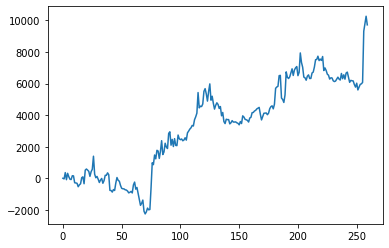

In [148]:
#シミュレーションを行う
money=[0]
profit=0
#haveはエントリーしていない、エントリーしている（sellは1,buyは2)を指す。
have=0
data=0
for i in range(len(ans)):
  #もっていない状態
  if have==0:
    #どういう行動を起こすか
    #stayなのでエントリーは行わない。
    if check[i]==0:
      continue
    #buyなのでbuyでエントリー
    if check[i]==2:
      have=2
      data=i
      continue
    #sellなのでsellでエントリー
    if check[i]==1:
      have=1
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がstayかsellだと予測した場合は保有
    if (check[i]==0 or check[i]==1):
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==2:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がstayかbuyだと予測した場合は保有を行う
    if (check[i]==0 or check[i]==2):
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
plt.plot(money)

**Tensorflow LSTMでsellとbuyの選択肢のみ**

In [54]:
df2

,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,44965.86,45390.5885,46470.316081,44310.860919,-183.907162,-124.689976,-59.217186,34.422632,37.051169
1,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
2,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
3,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
4,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
...,...,...,...,...,...,...,...,...,...
5961,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5962,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5963,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5964,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [99]:
df3

,price
0,44965.86
1,44654.39
2,44529.61
3,44637.84
4,44648.80
...,...
5961,54388.82
5962,54591.47
5963,54671.26
5964,54933.69


In [ ]:
#選択肢としてsell,stay,buyの3つを正解ラベルとして与える。
price=np.array(df3['price'])
print(price)
print(len(price))
PRICE=[]
sell=[]
buy=[]
print(price[0],price[1])
for i in range(len(price)-1):
  new=price[i+1]-price[i]
  PRICE.append(new)
  if 0<new:
    sell.append(0)
    buy.append(1)
  else:
    sell.append(1)
    buy.append(0)
print(PRICE)
print(sell)
print(buy)
print(len(sell),len(buy))
df5=df2[1:].reset_index(drop=True)
df5.insert(0,'sell',sell)
df5.insert(1,'buy',buy)

In [86]:
df5

,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
0,1,0,44654.39,45350.6455,46531.145587,44170.145413,-212.402074,-142.232396,-70.169679,25.696322,31.249201
1,1,0,44529.61,45298.9325,46584.388807,44013.476193,-242.260572,-162.238031,-80.022541,23.061477,29.271623
2,0,1,44637.84,45262.3665,46616.919708,43907.813292,-254.259446,-180.642314,-73.617132,30.059392,33.219226
3,0,1,44648.80,45215.3260,46606.770612,43823.881388,-259.888427,-196.491537,-63.396890,30.776678,33.623247
4,0,1,44659.13,45167.9625,46577.329451,43758.595549,-260.512861,-209.295801,-51.217059,31.521343,34.028367
...,...,...,...,...,...,...,...,...,...,...,...
5960,0,1,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,0,1,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,0,1,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5963,0,1,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [110]:
y_train[4]

array([1, 0])

In [106]:
df5[20:]

,sell,buy,price,sma20,bb_up,bb_low,macd,macdsignal,macdhist,rsi9,rsi14
20,0,1,44409.10,44579.7975,45109.421157,44050.173843,-206.241873,-201.379366,-4.862507,40.646709,39.055382
21,0,1,44411.87,44573.9105,45114.045386,44033.775614,-197.330802,-200.569654,3.238851,40.841843,39.175186
22,1,0,44408.89,44562.4630,45111.080754,44013.845246,-188.338131,-198.123349,9.785218,40.679976,39.086168
23,0,1,44581.69,44559.1075,45104.719199,44013.495801,-165.361671,-191.571014,26.209342,52.866108,46.655668
24,1,0,44453.27,44548.8145,45094.045916,44003.583084,-155.720039,-184.400819,28.680780,45.117083,42.435283
...,...,...,...,...,...,...,...,...,...,...,...
5960,0,1,54388.82,54577.5875,55920.551371,53234.623629,-664.554571,-772.072844,107.518273,42.765580,36.770630
5961,0,1,54591.47,54548.6435,55828.480821,53268.806179,-602.005447,-738.059365,136.053918,48.663916,40.998286
5962,0,1,54671.26,54513.3995,55664.673693,53362.125307,-539.774247,-698.402341,158.628094,50.905028,42.624923
5963,0,1,54933.69,54498.9480,55583.674461,53414.221539,-463.931749,-651.508223,187.576473,57.732569,47.729206


In [71]:
def create_window(window_size,split_size,df):
  train=[]
  test=[]
  price=np.array(df['price'])
  sma20=np.array(df['sma20'])
  bb_up=np.array(df['bb_up'])
  bb_low=np.array(df['bb_low'])
  macd=np.array(df['macd'])
  macdsignal=np.array(df['macdsignal'])
  macdhist=np.array(df['macdhist'])
  rsi9=np.array(df['rsi9'])
  rsi14=np.array(df['rsi14'])

  sell=np.array(df['sell'])
  buy=np.array(df['buy'])
  len_data=len(df['price'])

  for i in range(len_data-window_size):
    t=[]
    t.append(price[i:i+window_size])
    t.append(sma20[i:i+window_size])
    t.append(bb_up[i:i+window_size])
    t.append(bb_low[i:i+window_size])
    t.append(macd[i:i+window_size])
    t.append(macdsignal[i:i+window_size])
    t.append(macdhist[i:i+window_size])
    t.append(rsi9[i:i+window_size])
    t.append(rsi14[i:i+window_size])
    train.append(t)
    ans=[]
    ans.append(sell[i+window_size])
    ans.append(buy[i+window_size])
    test.append(ans)
  x_train,x_test=train[:int(len_data*split_size)],train[int(len_data*split_size):]
  y_train,y_test=test[:int(len_data*split_size)],test[int(len_data*split_size):]
  x_train=np.array(x_train)
  x_test=np.array(x_test)
  y_train=np.array(y_train)
  y_test=np.array(y_test)
  return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=create_window(20,0.8,df5)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,LSTM,Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Model
def create_LSTM_model():
  input=Input(shape=(x_train.shape[1],x_train.shape[2]))
  x=LSTM(64)(input)
  x=BatchNormalization()(x)
  x=Dense(32)(x)
  x=Dense(16)(x)
  output=Dense(y_train.shape[1],activation='softmax')(x)
  model=Model(input,output)
  return model
model=create_LSTM_model()
model.summary()
Adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=100,batch_size=32)

In [77]:
model.predict(x_test)

array([[0.50012386, 0.4998762 ],
       [0.4030623 , 0.5969377 ],
       [0.6347696 , 0.36523038],
       ...,
       [0.7770594 , 0.2229406 ],
       [0.76160586, 0.23839416],
       [0.75875545, 0.24124455]], dtype=float32)

In [80]:
y_train[0]

array([0, 1])

In [ ]:
print(len(model.predict(x_test)))
y_test[0]
check=[]
#testデータで精度の確認
ans=model.predict(x_test)
for i in range(len(ans)):
  if ans[i][0]>ans[i][1]:
    check.append(0)
  else:
    check.append(1)
answer=[]
for i in range(len(y_test)):
  if y_test[i][0]==1:
    answer.append(0)
  else:
    answer.append(1)
game=[]
for i in range(len(answer)):
  if answer[i]==check[i]:
    game.append('win')
  else:
    game.append('lose')
print(game.count('win'))
print(game.count('lose'))
print(answer)
price=np.array(df4['price'][-(len(y_test)):])
print(check)
print(price)

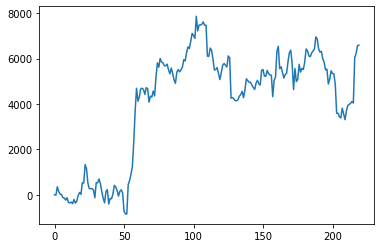

In [114]:
#シミュレーションを行う
money=[0]
profit=0
have=0
data=0
for i in range(len(ans)):
  if have==0:
    #sell
    if check[i]==0:
      have=1
      data=i
      continue
    #buy
    if check[i]==1:
      have=2
      data=i
      continue
  #sellでエントリーしている場合
  if have==1:
    #もし次がsellだと予測した場合は保有
    if check[i]==0:
      continue
    #もし次がbuyだと予測した場合は決済を行う
    if check[i]==1:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
  #buyでエントリーしている場合
  if have==2:
    #もし次がbuyだと予測した場合は保有を行う
    if check[i]==1:
      continue
    #もし次がsellだと予測した場合は決済を行う
    if check[i]==0:
      profit+=price[data]-price[i]
      money.append(profit)
      have=0
      continue
plt.plot(money)